In [22]:
# Cell 1: Imports & Setup
import os
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
from torchvision import models, transforms
import timm
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = (224, 224)
DATASET_ROOT = r"C:\Projects\Thesis-Fall-25-26--G-606-main"
IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [23]:
# Cell 2: Helper for Model Prediction
def make_predict_fn(model):
    def predict(images):
        images_torch = torch.stack([transform(img) for img in images]).to(DEVICE)
        model.eval()
        with torch.no_grad():
            outputs = model(images_torch)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        return probs
    return predict

In [24]:
# Cell 3: Choose a Test Image
test_img_name = "100_0.jpg"  # Using an existing fundus image from the dataset
img_path = os.path.join(IMAGES_DIR, test_img_name)
img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"Test image {test_img_name} not found in {IMAGES_DIR}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_for_lime = cv2.resize(img, IMG_SIZE)
print(f"Test image loaded: {test_img_name}")

Test image loaded: 100_0.jpg


In [25]:
# Cell 4: LIME Visualization Function
def show_lime(model, model_name, img_for_lime):
    explainer = LimeImageExplainer()
    predict_fn = make_predict_fn(model)
    explanation = explainer.explain_instance(
        img_for_lime,
        predict_fn,
        labels=[0,1],
        hide_color=0,
        num_samples=1000
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=10
    )
    plt.figure(figsize=(4,4))
    plt.title(f"LIME: {model_name}")
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis('off')
    plt.show()

100%|██████████| 1000/1000 [00:02<00:00, 405.72it/s]


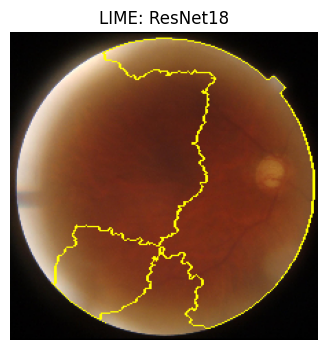

In [26]:
# Cell 5: LIME for ResNet18
resnet = models.resnet18(weights=None)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
model_path = os.path.join(DATASET_ROOT, "resnet18_best_model.pth")
resnet.load_state_dict(torch.load(model_path, map_location=DEVICE))
resnet = resnet.to(DEVICE)
show_lime(resnet, "ResNet18", img_for_lime)

100%|██████████| 1000/1000 [00:04<00:00, 236.95it/s]


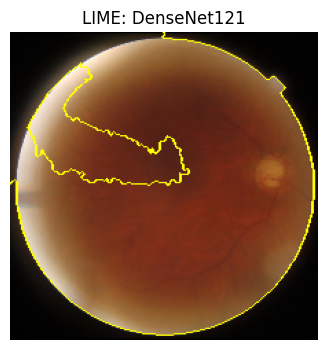

In [27]:
# Cell 6: LIME for DenseNet121
densenet = models.densenet121(weights=None)
densenet.classifier = nn.Linear(densenet.classifier.in_features, 2)
model_path = os.path.join(DATASET_ROOT, "densenet121_final_best.pth")  # From DenseNet121.ipynb final save
densenet.load_state_dict(torch.load(model_path, map_location=DEVICE))
densenet = densenet.to(DEVICE)
show_lime(densenet, "DenseNet121", img_for_lime)

100%|██████████| 1000/1000 [00:03<00:00, 319.52it/s]


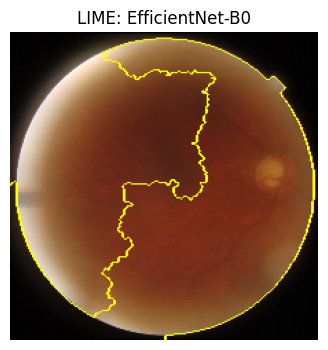

In [28]:
# Cell 7: LIME for EfficientNet-B0
# Note: EfficientNet was trained using torchvision, not timm
efficientnet = models.efficientnet_b0(weights=None)
num_features = efficientnet.classifier[1].in_features
efficientnet.classifier = nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(num_features, 2)
)
model_path = os.path.join(DATASET_ROOT, "efficientnet_b0_best_model.pth")
efficientnet.load_state_dict(torch.load(model_path, map_location=DEVICE))
efficientnet = efficientnet.to(DEVICE)
show_lime(efficientnet, "EfficientNet-B0", img_for_lime)

100%|██████████| 1000/1000 [00:04<00:00, 223.04it/s]


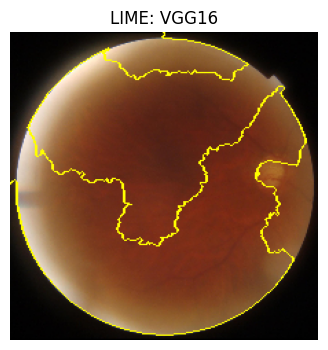

In [29]:
# Cell 8: LIME for VGG16
vgg = models.vgg16(weights=None)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 2)
model_path = os.path.join(DATASET_ROOT, "vgg16_best_model.pth")
vgg.load_state_dict(torch.load(model_path, map_location=DEVICE))
vgg = vgg.to(DEVICE)
show_lime(vgg, "VGG16", img_for_lime)

100%|██████████| 1000/1000 [00:02<00:00, 371.04it/s]


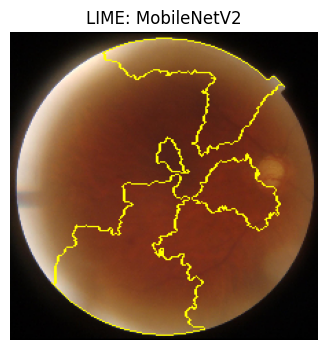

In [30]:
# Cell 9: LIME for MobileNetV2
mobilenet = models.mobilenet_v2(weights=None)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 2)
# Note: Uses best fold model - check MobileNetV2.ipynb output for exact fold number
model_path = os.path.join(DATASET_ROOT, "mobilenetv2_fold4_best.pth")
mobilenet.load_state_dict(torch.load(model_path, map_location=DEVICE))
mobilenet = mobilenet.to(DEVICE)
show_lime(mobilenet, "MobileNetV2", img_for_lime)

C:\Users\musfi\AppData\Roaming\Python\Python312\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
100%|██████████| 1000/1000 [00:03<00:00, 278.16it/s]


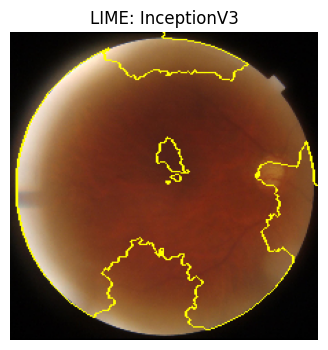

In [34]:
# Cell 10: LIME for InceptionV3
# Note: Model was trained with aux_logits=True but disabled during training
inception = models.inception_v3(weights=None)  # Default includes aux_logits=True
inception.aux_logits = False  # Disable aux_logits (matches training setup)
inception.fc = nn.Linear(inception.fc.in_features, 2)
# Note: Uses best fold model - check IcenptionV3.ipynb output for exact fold number
model_path = os.path.join(DATASET_ROOT, "inceptionv3_fold8_best.pth")
inception.load_state_dict(torch.load(model_path, map_location=DEVICE))
inception = inception.to(DEVICE)
show_lime(inception, "InceptionV3", img_for_lime)

100%|██████████| 1000/1000 [00:03<00:00, 254.42it/s]


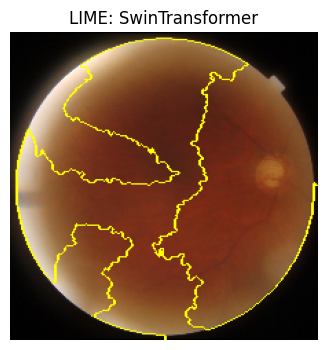

In [35]:
# Cell 11: LIME for SwinTransformer (Swin-Tiny)
swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=2)
# Note: Uses best fold model - check SwinTransformer.ipynb output for exact fold number
model_path = os.path.join(DATASET_ROOT, "swintransformer_fold1_best.pth")
swin.load_state_dict(torch.load(model_path, map_location=DEVICE))
swin = swin.to(DEVICE)
show_lime(swin, "SwinTransformer", img_for_lime)